In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
import torch
import networkx as nx
import matplotlib.pyplot as plt
import os

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [2]:
data_path = './ml-25m/'

ratings = pd.read_csv(data_path + 'ratings.csv')
movies = pd.read_csv(data_path + 'movies.csv')

print("Ratings data shape:", ratings.shape)
print("Movies data shape:", movies.shape)
print("\nRatings columns:", ratings.columns.tolist())
print("\nFirst few ratings:")
print(ratings.head())
print("\nInfo about ratings:")
ratings.info()

Ratings data shape: (25000095, 4)
Movies data shape: (62423, 3)

Ratings columns: ['userId', 'movieId', 'rating', 'timestamp']

First few ratings:
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510

Info about ratings:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [3]:
# Проверка на пропущенные значения
print("Missing values in ratings:")
print(ratings.isnull().sum())

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings = ratings.sort_values(by='timestamp').reset_index(drop=True)

print(f"Data range: from {ratings['timestamp'].min()} to {ratings['timestamp'].max()}")

Missing values in ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Data range: from 1995-01-09 11:46:49 to 2019-11-21 09:15:03


Formation of the target variable (Binarization of ratings)

The task is to predict whether a user will give a movie a high rating. This is a Link Prediction.

In [4]:
POSITIVE_RATING_THRESHOLD = 3.5

ratings['label'] = (ratings['rating'] >= POSITIVE_RATING_THRESHOLD).astype(int)

print("Distribution of labels (0 - low rating, 1 - high rating):")
print(ratings['label'].value_counts(normalize=True))

Distribution of labels (0 - low rating, 1 - high rating):
label
1    0.625203
0    0.374797
Name: proportion, dtype: float64


Graph construction

Bipartite Graph, where:

- Nodes of the same type: Users (user_id)
- Other type of nodes: Movies (movie_id)
- Edges: The existence of an interaction (the fact of evaluation) with the label.

In [5]:
# for convenience of working with the model, we will recode the user_id and movie_id into consecutive indexes (0..N-1)

# create mappings of source IDs to internal indexes
unique_users = ratings['userId'].unique()
unique_movies = ratings['movieId'].unique()

user_to_idx = {orig_id: new_idx for new_idx, orig_id in enumerate(unique_users)}
movie_to_idx = {orig_id: new_idx for new_idx, orig_id in enumerate(unique_movies)}

# check mappings
ratings['user_idx'] = ratings['userId'].map(user_to_idx)
ratings['movie_idx'] = ratings['movieId'].map(movie_to_idx)

print(f"Total users: {len(unique_users)}")
print(f"Total movies: {len(unique_movies)}")
print(f"Total interactions: {len(ratings)}")

Total users: 162541
Total movies: 59047
Total interactions: 25000095


train/test

In [6]:
# last 20% by time - test
split_point = int(0.8 * len(ratings))

train_ratings = ratings.iloc[:split_point]
test_ratings = ratings.iloc[split_point:]

print(f"Train set size: {len(train_ratings)}")
print(f"Test set size: {len(test_ratings)}")

# Make sure that only users and movies from the train are included in the test
# This is an important step for realistic model evaluation
test_ratings = test_ratings[
    (test_ratings['user_idx'].isin(train_ratings['user_idx'].unique())) &
    (test_ratings['movie_idx'].isin(train_ratings['movie_idx'].unique()))
]
print(f"Test set size after filtering cold-start interactions: {len(test_ratings)}")

Train set size: 20000076
Test set size: 5000019
Test set size after filtering cold-start interactions: 610664


In [7]:
# create a sparse matrix for the training set
n_users = len(unique_users)
n_movies = len(unique_movies)

# Interaction matrix (1 - there was an interaction, 0 - there was no interaction)
# But in our case, we can use binary labels or the ratings themselves.
# For the binary classification of link prediction, we use binary labels.

def create_sparse_matrix(df, n_rows, n_cols, row_col='user_idx', col_col='movie_idx', value_col='label'):
    """Создает sparse matrix взаимодействий из DataFrame."""
    rows = df[row_col].values
    cols = df[col_col].values
    data = df[value_col].values
    return sp.csr_matrix((data, (rows, cols)), shape=(n_rows, n_cols))

# matrix for train
train_matrix = create_sparse_matrix(train_ratings, n_users, n_movies)

test_matrix = create_sparse_matrix(test_ratings, n_users, n_movies)

print(f"Train matrix shape: {train_matrix.shape}, density: {train_matrix.nnz / (n_users * n_movies):.6f}")
print(f"Test matrix shape: {test_matrix.shape}, density: {test_matrix.nnz / (n_users * n_movies):.6f}")

Train matrix shape: (162541, 59047), density: 0.002084
Test matrix shape: (162541, 59047), density: 0.000064


In [8]:
# The adjacency matrix for the bipartite graph User-Item has the form:
# [0, R]
# [R^T, 0]
# where R is our interaction matrix.

def create_adjacency_matrix(interaction_matrix):
    """Creates an adjacency matrix for a bipartite user-movie graph."""
    n_users, n_items = interaction_matrix.shape
    
    # Upper right part: R
    # Lower left part: R^T
    # Diagonal blocks (user-user, movie-movie) are zero.
    
    A = sp.bmat([
        [sp.csr_matrix((n_users, n_users)), interaction_matrix],
        [interaction_matrix.T, sp.csr_matrix((n_items, n_items))]
    ])
    return A

adj_matrix = create_adjacency_matrix(train_matrix)
print(f"Full graph adjacency matrix shape: {adj_matrix.shape}")

Full graph adjacency matrix shape: (221588, 221588)


In [9]:
output_dir = './preprocessed_data/'
os.makedirs(output_dir, exist_ok=True)

# save sparse matrices
sp.save_npz(output_dir + 'train_matrix.npz', train_matrix)
sp.save_npz(output_dir + 'test_matrix.npz', test_matrix)
sp.save_npz(output_dir + 'adj_matrix.npz', adj_matrix)

# save the mappings
np.save(output_dir + 'user_to_idx.npy', user_to_idx)
np.save(output_dir + 'movie_to_idx.npy', movie_to_idx)

# save DataFrames with ratings
train_ratings.to_csv(output_dir + 'train_ratings.csv', index=False)
test_ratings.to_csv(output_dir + 'test_ratings.csv', index=False)

# save size information
with open(output_dir + 'data_info.txt', 'w') as f:
    f.write(f"n_users: {n_users}\n")
    f.write(f"n_movies: {n_movies}\n")
    f.write(f"n_interactions_train: {train_matrix.nnz}\n")
    f.write(f"n_interactions_test: {test_matrix.nnz}\n")

print("Data has been successfully saved to the folder:", output_dir)

Data has been successfully saved to the folder: ./preprocessed_data/


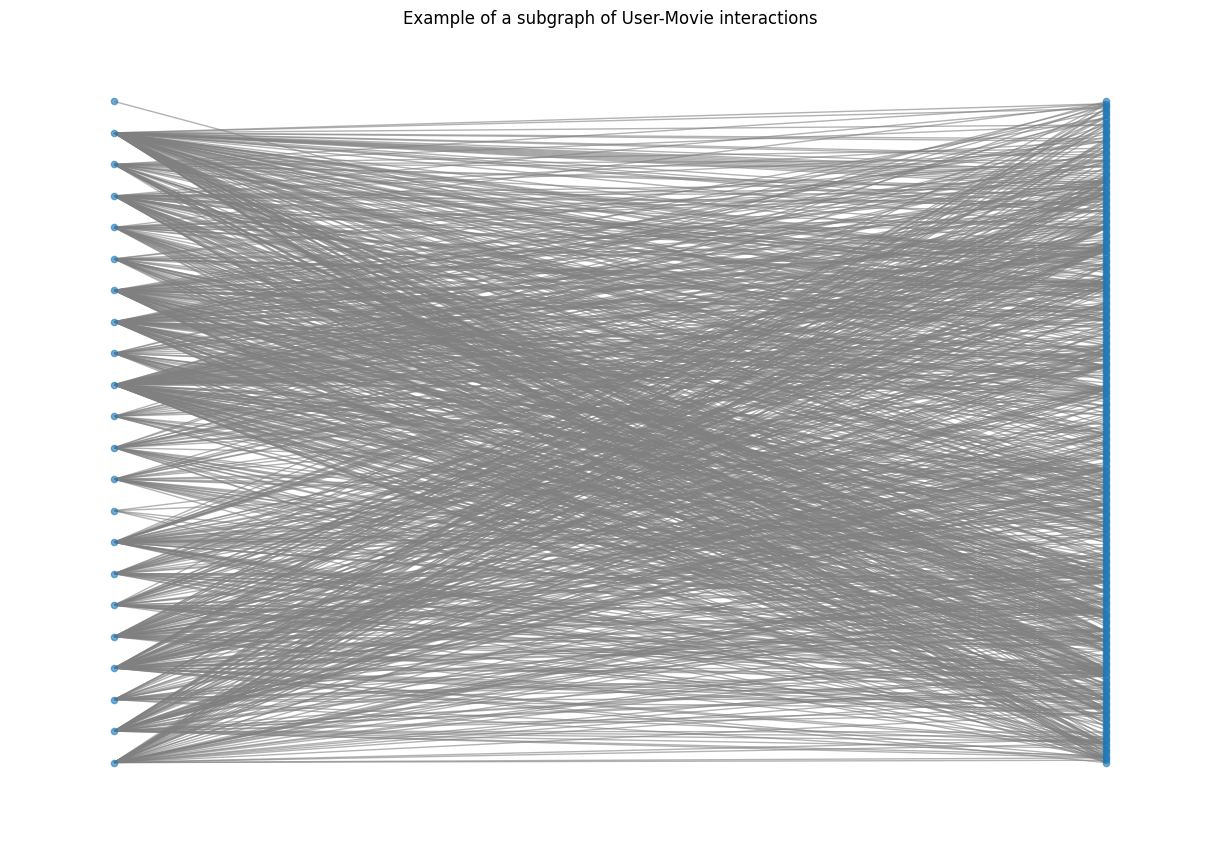

In [10]:
# Visualize a small subgraph to understand the structure
sample_size = 1000
sample_users = np.random.choice(train_ratings['user_idx'].unique(), size=sample_size//2, replace=False)
sample_df = train_ratings[train_ratings['user_idx'].isin(sample_users)].head(sample_size)

G = nx.Graph()
user_nodes = [f"u{idx}" for idx in sample_df['user_idx'].values]
movie_nodes = [f"m{idx}" for idx in sample_df['movie_idx'].values]

G.add_nodes_from(user_nodes, bipartite=0)
G.add_nodes_from(movie_nodes, bipartite=1)
edges = [(f"u{u}", f"m{m}") for u, m in zip(sample_df['user_idx'], sample_df['movie_idx'])]
G.add_edges_from(edges)

plt.figure(figsize=(12, 8))
pos = nx.bipartite_layout(G, user_nodes)
nx.draw(G, pos, with_labels=False, node_size=20, alpha=0.6, edge_color='gray')
plt.title("Example of a subgraph of User-Movie interactions")
plt.show()